# Ice Online Store: análisis para proyectar las ventas del 2017

Ice es una tieda virtual de videojuegos que vende por todo el mundo. La base de datos del análisis cuenta con:
- las reseñas de usuarios y expertos
- los géneros
- las plataformas (por ejemplo, Xbox o PlayStation)
- los datos históricos sobre las ventas de juegos

El siguiente análisis busca identificar patrones que determinan si un juego tiene éxito o no. Esto permitirá a la tienda y sus áreas respectivas el detectar proyectos prometedores y planificar campañas publicitarias.

## Librerías utilizadas para el análisis: 

In [1]:
import pandas as pd
from scipy import stats as st
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import math


In [2]:
ice_df = pd.read_csv('./games.csv')

In [3]:
ice_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [4]:
ice_df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


## 1. Preprocesamiento: 

1. Cambiar los nombres de las columnas a letras minúsculas.
2. Revisar y cambiar los datos a los tipos que sean necesarios.
3. Evaluar los datos ausentes y tratarlos según sea el caso (eliminarlos, rellenarlos o dejarlos como ausentes).
4. Crear una nueva columna que evidencie las ventas totales de cada videojuego.

In [5]:
#Letras minúsculas para los nombres de las columnas:

ice_df.columns = ice_df.columns.str.lower()

ice_df.sample(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
8654,Trigger Man,PS2,2004.0,Shooter,0.08,0.06,0.00,0.02,32.0,4.8,T
4054,Sonic & All-Stars Racing Transformed,PS3,2012.0,Racing,0.08,0.30,0.01,0.09,NaN,NaN,NaN
8252,Ice Age: Dawn of the Dinosaurs,PS2,2009.0,Action,0.08,0.07,0.00,0.02,NaN,tbd,E10+
5514,Sakura Wars 3: Paris wa Moeteiru ka,DC,2001.0,Adventure,0.00,0.00,0.33,0.00,NaN,NaN,NaN
14807,Greg Hastings' Tournament Paintball Max'd,GBA,2006.0,Shooter,0.02,0.01,0.00,0.00,NaN,tbd,E10+
16545,Madagascar: Escape 2 Africa,PC,2008.0,Action,0.01,0.00,0.00,0.00,58.0,8,E10+
3470,Championship Motocross featuring Ricky Carmichael,PS,1998.0,Racing,0.32,0.22,0.00,0.04,NaN,NaN,NaN
5685,Chicken Blaster,Wii,2009.0,Shooter,0.29,0.00,0.00,0.02,NaN,tbd,T
10290,Final Fantasy I & II,NES,1994.0,Role-Playing,0.00,0.00,0.11,0.00,NaN,NaN,NaN
10746,Derby Jockey 2,SNES,1995.0,Sports,0.00,0.00,0.10,0.00,NaN,NaN,NaN


Se identifica una columna a la que se le debe cambiar el tipo de dato: 

- user_score de object a float, este cambio es completamente necesario, ya que solo así se podrán hacer las operaciones matemáticas necesarias con los puntajes de cada videojuego. 

In [6]:
#Identificar los datos tbd para evaluar si se pueden pasar a ausentes. 

tbd_list = ice_df['user_score'] == 'tbd'

print(f' El todal de user_score marcado como tbd es: {tbd_list.sum()}')

ice_df[tbd_list].head(5)

 El todal de user_score marcado como tbd es: 2424


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010.0,Sports,3.45,2.59,0.0,0.66,NaN,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005.0,Misc,2.08,1.35,0.0,0.54,61.0,tbd,E10+
520,Zumba Fitness 2,Wii,2011.0,Sports,1.51,1.03,0.0,0.27,NaN,tbd,T
645,uDraw Studio,Wii,2010.0,Misc,1.65,0.57,0.0,0.20,71.0,tbd,E
657,Frogger's Adventures: Temple of the Frog,GBA,NaN,Adventure,2.15,0.18,0.0,0.07,73.0,tbd,E


Con la anterior tabla evalué si todos los valores 'tbd' eran del último año contabilizado (2016) al no ser así determiné que no se recibirá un 'user_score' pronto, por lo cual estos valores pueden ser manejados como ausentes y no alterar las conclusiones. 

Por lo anterior, puedo proseguir cambiando todos los valores a float, ignorando errores al ajustar el parámetro a 'coerce'.

In [7]:
#Pasar toda la columna 'user_score' a tipo float convirtiendo a su vez los tbd a datos ausentes.

ice_df['user_score'] = pd.to_numeric(ice_df['user_score'], errors='coerce')

print(ice_df.dtypes)

name                object
platform            object
year_of_release    float64
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score       float64
user_score         float64
rating              object
dtype: object


In [8]:
#Identificar la cantidad y porcentaje de valores ausentes y su ubicación entre las columnas

print(ice_df.isna().sum())
print()
print(100*ice_df.isna().sum()/ice_df.shape[0])

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         9125
rating             6766
dtype: int64

name                0.011965
platform            0.000000
year_of_release     1.609333
genre               0.011965
na_sales            0.000000
eu_sales            0.000000
jp_sales            0.000000
other_sales         0.000000
critic_score       51.319174
user_score         54.591684
rating             40.478612
dtype: float64


In [9]:
ice_df[ice_df['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Por los datos anteriores se tomaron dos determinaciones: 

1. Los valores ausentes de la columnna 'name', al ser solo 2, se eliminarán, ya que son una muestra poco significatica y en ambos casos falta aún más información.

2. Los datos ausentes de la columna 'year_of_release', al no representar un porcentaje significativo frente a todo el data frame, también se eliminará para no afectar las gráficas del análisis, además sus datos se cambiarán al tipo int. 

3. Las columnas 'critic_score', 'user_score' y 'rating' se dejarán como datos ausentes, ya que al ser tantos, y tratarse de números, cambiarlos afectaría las operaciones matemáticas más adelante en el análisis. 

In [10]:
#Proceso para eliminar los datos ausentes

ice_df = ice_df.dropna(subset=['name', 'year_of_release'])

ice_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  float64
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           9768 non-null   object 
dtypes: float64(7), object(4)
memory usage: 1.5+ MB


In [11]:
#Cambio de la columna año al tipo int

ice_df['year_of_release'] = ice_df['year_of_release'].astype('int')

ice_df['year_of_release'].info()

<class 'pandas.core.series.Series'>
Index: 16444 entries, 0 to 16714
Series name: year_of_release
Non-Null Count  Dtype
--------------  -----
16444 non-null  int64
dtypes: int64(1)
memory usage: 256.9 KB


In [12]:
#Crear una columna adicional con la cifra de las ventas totales por videojuego.

ice_df['total_sales'] = ice_df['na_sales'] + ice_df['eu_sales'] + ice_df['jp_sales'] + ice_df['other_sales']

ice_df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


## 2. Análisis de datos

1. ¿Cuántos juegos fueron lanzados en diferentes años? ¿Son significativos los datos de cada período?
2. ¿Cómo varían las ventas de una plataforma a otra? Elección de las plataformas con las mayores ventas totales por año. ¿Cuánto tardan generalmente las nuevas plataformas en aparecer y las antiguas en desaparecer?
3. Determinar para qué período debemos tomar datos para construir un modelo para el 2017.
4. ¿Qué plataformas son líderes en ventas? ¿Cuáles crecen y cuáles se reducen? Elección de varias plataformas potencialmente rentables.
5. Diagrama de caja para las ventas globales de todos los juegos, desglosados por plataforma. ¿Son significativas las diferencias en las ventas? ¿Qué sucede con las ventas promedio en varias plataformas?
6. ¿Cómo las reseñas de usuarios y profesionales afectan las ventas de una plataforma popular? Gráfico de dispersión y correlación entre las reseñas y las ventas.
7. Comparación de las ventas de los mismos juegos en otras plataformas.
8. Distribución general de los juegos por género. ¿Qué se puede decir de los géneros más rentables? ¿Se puede generalizar acerca de los géneros con ventas altas y bajas?

### Lanzamientos por año

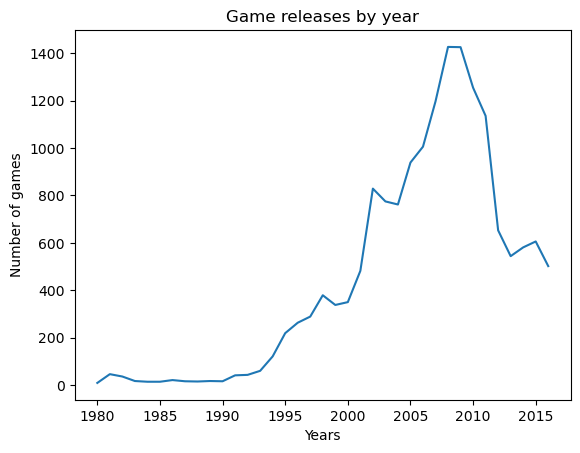

In [13]:
games_by_year = ice_df.groupby('year_of_release')['name'].count().reset_index()

sns.lineplot(data = games_by_year,
             x = 'year_of_release',
             y = 'name')

plt.title('Game releases by year')
plt.xlabel('Years')
plt.ylabel('Number of games')
plt.show()

Según la gráfica, a partir de 2001 se supera el umbral de los 400 juegos lanzados por año, siendo un año con mucho más movimiento y que nos permite descartar años previos. 

In [14]:
sales_by_platform = ice_df.groupby('platform')['total_sales'].sum().reset_index().sort_values(by = 'total_sales', ascending = False)

sales_by_platform.head()

,platform,total_sales
16,PS2,1233.56
28,X360,961.24
17,PS3,931.34
26,Wii,891.18
4,DS,802.78


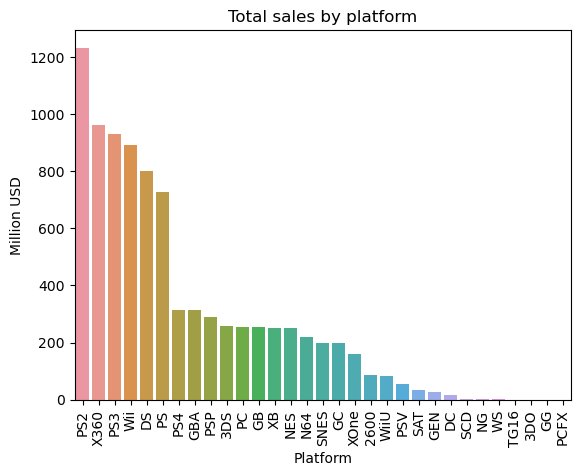

In [15]:
sns.barplot(data = sales_by_platform, x = 'platform', y = 'total_sales')

plt.title('Total sales by platform')
plt.xlabel('Platform')
plt.ylabel('Million USD')
plt.xticks(rotation = 90)
plt.show()

Las plataformas con más ventas de manera histórica son: 

1. PlayStation 2
2. Xbox 360
3. PlayStation 3
4. Nintendo Wii
5. Nintendo DS

In [16]:
platform_list = ('PS2', 'X360', 'PS3', 'Wii', 'DS')

top_consoles_df = ice_df[ice_df['platform'].isin(platform_list)]

top_consoles_df.sample(2)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
4829,Monster Trucks Mayhem,Wii,2009,Racing,0.38,0.0,0.0,0.02,NaN,NaN,E,0.40
13796,North American Hunting Extravaganza 2,Wii,2010,Sports,0.03,0.0,0.0,0.00,NaN,NaN,NaN,0.03


In [17]:
platform_sales_by_year = top_consoles_df.groupby(['platform', 'year_of_release'])['total_sales'].sum().reset_index()

platform_sales_by_year.sample(2)

,platform,year_of_release,total_sales
25,PS3,2008,118.52
30,PS3,2013,113.25


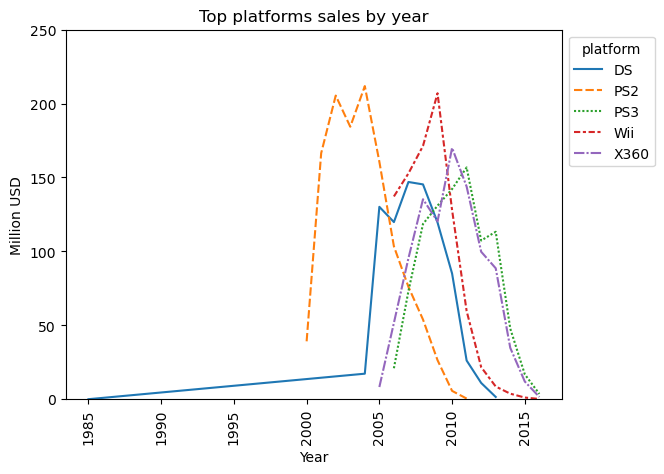

In [18]:
graphic = sns.lineplot(data = platform_sales_by_year,
            x = 'year_of_release',
            y = 'total_sales',
            style = 'platform',
            hue = 'platform')

plt.xticks(rotation = 90)
plt.title('Top platforms sales by year')
plt.xlabel('Year')
plt.ylabel('Million USD')
sns.move_legend(graphic, 'upper left', bbox_to_anchor = (1, 1))
graphic.set_ylim(0, 250)
plt.show()

Al observar la anterior gráfica podemos observar varias cosas: 

- La mayoría de consolas tienen un periodo o ciclo de 'vida' en ventas de aproximadamente 10 años. 
- Los picos en ventas de las consolas se alcanzan, por lo general, en los primeros 5 años tras su lanzamiento. 
- Más o menos a mediados del periodo de vida de una consola, surge la siguiente con mayor éxito en ventas.

Otras observaciones:
- Hay datos anormales o valores atípicos de la consola Nintendo DS, ya que sus ventas se remontan a 1985.

Conclusiones: 
- Para las evaluaciones a continuación, se considerará un periodo de 5 años previos al 2017, es decir, tomaré datos a partir del 2012. Esto con la intención de no sobreestimar las ventas de una consola al tomar su ciclo de vida completo.

### Datos elegidos para continuar el análisis

A partir de las gráficas elaboradas hasta este punto, se ha determinado que solo **se tomarán los últimos 5 años de registros, es decir, del 2012 hasta el 2016, y así hacer un estimación de las necesidades para el 2017.** 

In [19]:
final_ice_df = ice_df[ice_df['year_of_release'] >= 2012].reset_index(drop = True)

final_ice_df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
1,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
2,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
3,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,NaN,14.60
4,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,13.79


In [20]:
platform_sales_2012 = final_ice_df.groupby('platform')['total_sales'].sum().reset_index().sort_values('total_sales', ascending = False)

platform_sales_2012.head(5)

,platform,total_sales
4,PS4,314.14
3,PS3,288.79
9,X360,236.54
0,3DS,194.61
10,XOne,159.32


### Plataformas líderes en ventas a partir del 2012: 

1. PS4
2. PS3
3. X360
4. 3DS
5. XOne

In [21]:
platform_list_2012 = ('PS4', 'PS3', 'X360', '3DS', 'XOne')

top_sales_platforms = final_ice_df[final_ice_df['platform'].isin(platform_list_2012)]

top_sales_platforms.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
1,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
2,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
3,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,NaN,14.60
4,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,13.79


In [22]:
sales_since_2012 = top_sales_platforms.groupby(['platform', 'year_of_release'])['total_sales'].sum().reset_index()

sales_since_2012.sample(5)

,platform,year_of_release,total_sales
13,PS4,2016,69.25
2,3DS,2014,43.76
11,PS4,2014,100.00
21,XOne,2015,60.14
7,PS3,2014,47.76


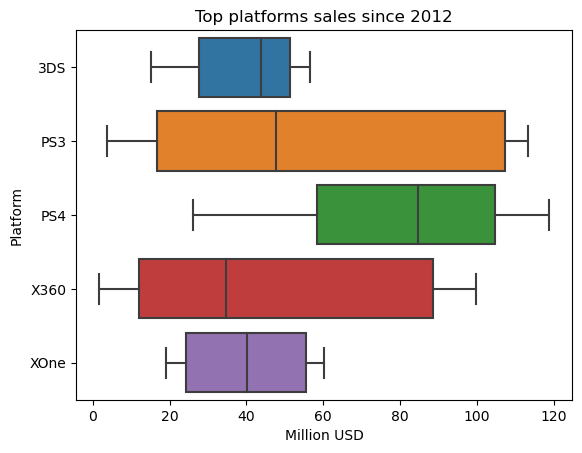

In [23]:
sns.boxplot(data = sales_since_2012,
            x = 'total_sales', 
            y = 'platform')


plt.title('Top platforms sales since 2012')
plt.xlabel('Million USD')
plt.ylabel('Platform')
plt.show()

En el diagrama de caja podemos ver comportamientos muy disímiles entre las diferentes plataformas más vendidas apartir del 2012, por ejemplo, algunas de las observaciones son: 

- Sí existen diferencias significativas en ventas de una plataforma a otra, por ejemplo, el PS4, plataforma con más ventas, el 75 % de sus datos se concentran en ventas mayores a las que tuvo en este periodo de tiempo la Xbox One y el Nintendo 3DS; y siguiendo esta misma línea, ese 75 % de ventas de la PS4 rondan las mismas cifras que tan solo el 25 % de mayor ingreso del PS3 y la Xbox 360 lograron alcanzar en su mejor momento. 

- El alcance de las ventas la Xbox One y el Nintendo 3DS es mucho más concentrado en cifras de 20 a 60 millones de USD, mientras que las otras consolas tienen picos y valles muchos más separados entre sí.

### Análisis del Xbox 360 según las reseñas de los usuarios y profesionales



In [24]:
X360_analysis = final_ice_df[final_ice_df['platform'] == 'X360'].reset_index(drop = True)

X360_analysis.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
1,Call of Duty: Black Ops II,X360,2012,Shooter,8.25,4.24,0.07,1.12,83.0,4.8,M,13.68
2,Call of Duty: Ghosts,X360,2013,Shooter,6.73,2.56,0.04,0.91,73.0,2.6,M,10.24
3,Halo 4,X360,2012,Shooter,6.65,2.28,0.04,0.74,87.0,7.0,M,9.71
4,Minecraft,X360,2013,Misc,5.70,2.65,0.02,0.81,NaN,NaN,NaN,9.18


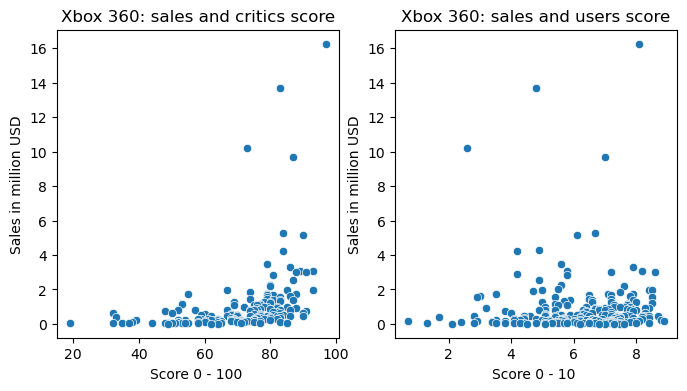

In [25]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))



sns.scatterplot(data = X360_analysis,
            ax = ax1, 
            x = 'critic_score', 
            y = 'total_sales')

plt.subplot(1, 2, 1)
plt.title('Xbox 360: sales and critics score')
plt.xlabel('Score 0 - 100 ')
plt.ylabel('Sales in million USD')

sns.scatterplot(data = X360_analysis,
            ax = ax2, 
            x = 'user_score', 
            y = 'total_sales')

plt.subplot(1, 2, 2)
plt.title('Xbox 360: sales and users score')
plt.xlabel('Score 0 - 10 ')
plt.ylabel('Sales in million USD')

plt.show()

In [26]:
print(f" El coeficiente de correlación entre las críticas de los expertos y las ventas es: {(X360_analysis['total_sales'].corr(X360_analysis['critic_score'])).round(2)}")
print()
print(f" El coeficiente de correlación entre las críticas de los usuarios y las ventas es: {(X360_analysis['total_sales'].corr(X360_analysis['user_score'])).round(2)}")

 El coeficiente de correlación entre las críticas de los expertos y las ventas es: 0.36

 El coeficiente de correlación entre las críticas de los usuarios y las ventas es: 0.01


Con la gráfica de dispersión y el coeficiente de correlación calculado podemos concluir que sí hay una correlación positiva un tanto sutil cuando de las críticas de los expertos se trata, es decir, a medida que las críticas son más positivas se puede observar un incremento en las ventas.

Esto no ocurre con las críticas de los usuarios, donde el coeficiente de correlación es muy bajo y vemos eventos como el que un juego con calificaciones muy bajas aún así cuente con buenas ventas. 

### Juegos multiplataformas

In [27]:
mp_games = final_ice_df.groupby('name')['platform'].count().reset_index()

mp_games = mp_games[mp_games['platform'] > 2] #elegí a apartir de 2 para evaluar más plataformas

mp_games = mp_games.name.unique()

mp_games

array(['AKB1/149: Love Election',
       "Adventure Time: Explore the Dungeon Because I Don't Know!",
       'Adventure Time: Finn & Jake Investigations',
       'Aegis of Earth: Protonovus Assault',
       "Akiba's Trip: Undead & Undressed", 'Alien: Isolation',
       'Aliens: Colonial Marines', 'Angry Birds Star Wars',
       'Angry Birds Trilogy', 'Arslan: The Warriors of Legend',
       "Assassin's Creed Chronicles", "Assassin's Creed III",
       "Assassin's Creed IV: Black Flag", "Assassin's Creed Syndicate",
       "Assassin's Creed: Rogue", "Assassin's Creed: Unity",
       'Atelier Sophie: The Alchemist of the Mysterious Book',
       'Attack on Titan (KOEI)', 'Back to the Future: The Game',
       'Barbie and Her Sisters Puppy Rescue',
       'Batman: A Telltale Game Series', 'Batman: Arkham Knight',
       'Batman: Arkham Origins', 'Battleborn', 'Battlefield 1',
       'Battlefield 4', 'Battlefield: Hardline', 'BioShock Infinite',
       'Bladestorm: Nightmare', 'BlazBlue: C

In [28]:
lego_batman = final_ice_df[final_ice_df['name'] == 'LEGO Batman 2: DC Super Heroes']

lego_batman

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
199,LEGO Batman 2: DC Super Heroes,X360,2012,Action,0.90,0.61,0.0,0.15,79.0,7.2,E10+,1.66
241,LEGO Batman 2: DC Super Heroes,Wii,2012,Action,0.90,0.37,0.0,0.11,NaN,7.1,E10+,1.38
286,LEGO Batman 2: DC Super Heroes,PS3,2012,Action,0.50,0.50,0.0,0.19,81.0,7.5,E10+,1.19
454,LEGO Batman 2: DC Super Heroes,3DS,2012,Action,0.41,0.28,0.0,0.06,72.0,5.2,E10+,0.75
500,LEGO Batman 2: DC Super Heroes,DS,2012,Action,0.39,0.24,0.0,0.06,NaN,8.0,E10+,0.69
857,LEGO Batman 2: DC Super Heroes,PSV,2012,Action,0.16,0.11,0.0,0.06,62.0,6.7,E10+,0.33
1478,LEGO Batman 2: DC Super Heroes,WiiU,2013,Action,0.04,0.06,0.0,0.01,77.0,7.3,E10+,0.11


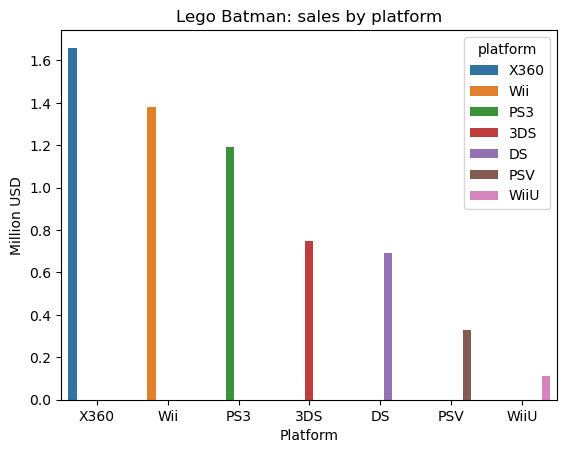

In [29]:
sns.barplot(data = lego_batman,
             x = 'platform', 
             y = 'total_sales',
             hue = 'platform')

plt.title('Lego Batman: sales by platform')
plt.xlabel('Platform')
plt.ylabel('Million USD')
plt.show()

In [30]:
lego_ring = final_ice_df[final_ice_df['name'] == 'LEGO The Lord of the Rings']

lego_ring

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
281,LEGO The Lord of the Rings,X360,2012,Action,0.64,0.49,0.0,0.11,80.0,8.5,E10+,1.24
323,LEGO The Lord of the Rings,PS3,2012,Action,0.37,0.49,0.0,0.19,82.0,8.3,E10+,1.05
392,LEGO The Lord of the Rings,Wii,2012,Action,0.48,0.34,0.0,0.07,NaN,7.2,E10+,0.89
763,LEGO The Lord of the Rings,3DS,2012,Action,0.20,0.16,0.0,0.03,61.0,7.6,E10+,0.39
939,LEGO The Lord of the Rings,PSV,2012,Action,0.09,0.13,0.0,0.06,54.0,5.6,E10+,0.28
1089,LEGO The Lord of the Rings,PC,2012,Action,0.07,0.13,0.0,0.03,80.0,8.2,E10+,0.23
1385,LEGO The Lord of the Rings,DS,2012,Action,0.00,0.12,0.0,0.01,NaN,NaN,E10+,0.13


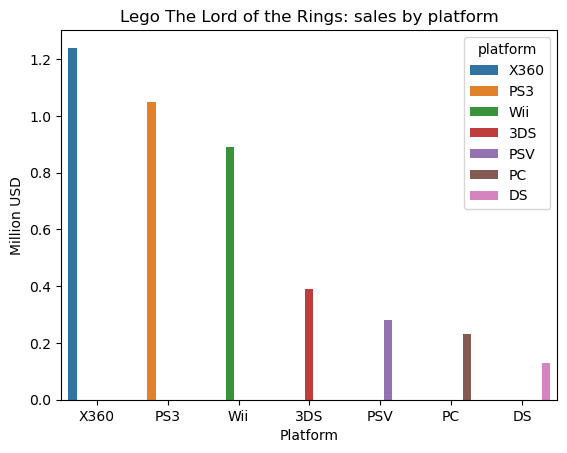

In [31]:
sns.barplot(data = lego_ring,
             x = 'platform', 
             y = 'total_sales',
             hue = 'platform')

plt.title('Lego The Lord of the Rings: sales by platform')
plt.xlabel('Platform')
plt.ylabel('Million USD')

plt.show()

Para las comparaciones elegí dos juegos de Lego, ya que están presentes en más de dos plataformas, en ambos casos hay una consola con mayor éxito en ventas frente a las demás y esta es la Xbox 360.

Además, vemos que si bien las ventas pueden ser pequeñas, en todas las consolas en las que han salido, ambos juegos se han vendido, no fueron un fracaso total. 

### Comparaciones por géneros

In [32]:
genre_comparison = final_ice_df.groupby(['year_of_release','genre'])['total_sales'].sum().reset_index().sort_values(by = 'total_sales', ascending = False)

genre_comparison['year_of_release'].unique()

array([2013, 2012, 2014, 2015, 2016])

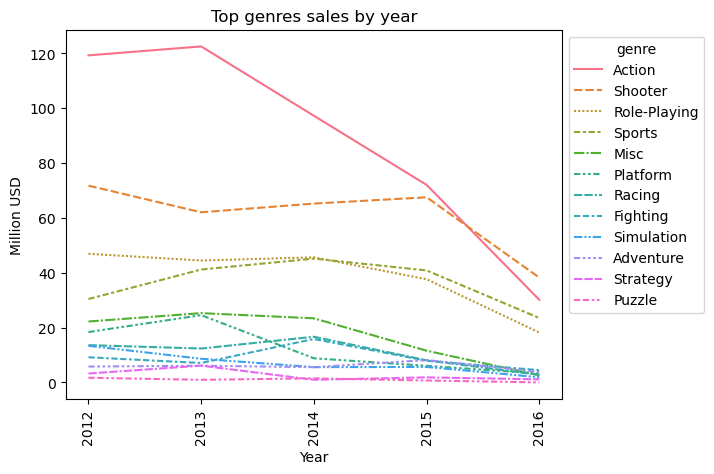

In [33]:
genre_graphic = sns.lineplot(data = genre_comparison,
                             x = 'year_of_release', 
                             y = 'total_sales',
                             hue = 'genre', 
                             style = 'genre')

plt.xticks(rotation = 90)
plt.title('Top genres sales by year')
plt.xlabel('Year')
plt.ylabel('Million USD')
sns.move_legend(genre_graphic, 'upper left', bbox_to_anchor = (1, 1))
genre_graphic.set_xticks(range(2012, 2017))

plt.show()

La anterior gráfica nos muestra claramente cómo hay 4 géneros favoritos, sus ventas siempre son superiores a las demás desde el 2012, estos son: 

1. Action
2. Shooter
3. Role-playing
4. Sports

El género Action, si bien estuvo en la cima en ventas por mucho y por más tiempo, llegando al 2016 fue superado en ventas por Shooter; sin embargo, hay que tener en cuenta que este último género parece estar decreciendo en ventas desde el último año al igual que todos los demás géneros favoritos. 

In [34]:
final_ice_df.head(2)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
1,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27


## 3. Perfil de usuario para cada región

Para cada región (NA, UE, JP) se determinará :
- Las cinco plataformas principales. Variaciones en sus cuotas de mercado de una región a otra.
- Los cinco géneros principales.
- Si las clasificaciones de ESRB afectan a las ventas en regiones individuales.


In [35]:
region = top_sales_platforms.groupby(['platform', 'rating']).agg({'na_sales': 'sum', 'eu_sales': 'sum',
                                                     'jp_sales': 'sum','other_sales': 'sum',}).reset_index()
region.head()

,platform,rating,na_sales,eu_sales,jp_sales,other_sales
0,3DS,E,17.31,14.64,16.29,2.89
1,3DS,E10+,8.33,5.52,3.89,1.22
2,3DS,M,1.34,0.42,1.49,0.17
3,3DS,T,3.58,1.85,6.12,0.50
4,PS3,E,20.85,24.75,2.76,9.40


In [36]:
region_sales = pd.melt(region, id_vars = ['platform'], value_vars=['na_sales', 'eu_sales', 'jp_sales', 'other_sales'], var_name = 'region', value_name = 'sales')

region_sales.head()

,platform,region,sales
0,3DS,na_sales,17.31
1,3DS,na_sales,8.33
2,3DS,na_sales,1.34
3,3DS,na_sales,3.58
4,PS3,na_sales,20.85


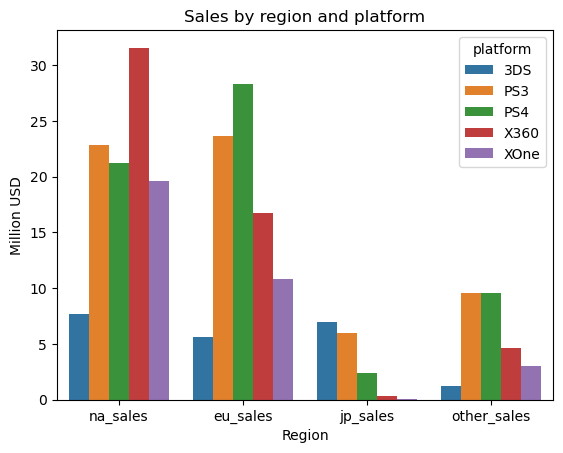

In [37]:
sns.barplot(data = region_sales, 
            x = 'region', 
            y = 'sales', 
            hue = 'platform',
            errorbar = None)

plt.title('Sales by region and platform')
plt.xlabel('Region')
plt.ylabel('Million USD')

plt.show()

Podemos extraer mucha información de la anterior gráfica: 
- Norte América y la Unión europea poseen las mejores ventas en conjunto, superando las de Japón y otras regiones. 
- Las consolas favoritas en Norte América, Unión europea y Japón son Xbox 360, PS4 y Nintendo 3DS respectivamente.
- Consolas como la Xbox One y la Xbox 360 no son populares y han generado un mínimo de ventas en Japón.
- Las ventas de Xbox 360 en Norte América superan las ventas de cualquier otra consola en cualquier otra región.

In [38]:
genre_list_2012 = ('Action', 'Shooter', 'Role-Playing', 'Sports', 'Misc')

top_sales_genres = final_ice_df[final_ice_df['genre'].isin(genre_list_2012)]

top_sales_genres.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
1,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
2,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
3,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,NaN,14.60
4,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,13.79


In [39]:
genre_by_region = top_sales_genres.groupby('genre').agg({'na_sales': 'sum', 'eu_sales': 'sum',
                                                     'jp_sales': 'sum','other_sales': 'sum',}).reset_index()
genre_by_region.head()

,genre,na_sales,eu_sales,jp_sales,other_sales
0,Action,177.84,159.34,52.80,51.14
1,Misc,38.19,26.32,12.86,7.67
2,Role-Playing,64.00,48.53,65.44,14.83
3,Shooter,144.77,113.47,9.23,37.26
4,Sports,81.53,69.09,8.01,22.44


In [40]:
genre_sales = pd.melt(genre_by_region, id_vars = ['genre'], value_vars=['na_sales', 'eu_sales', 'jp_sales', 'other_sales'], var_name = 'region', value_name = 'sales')

genre_sales.head()

,genre,region,sales
0,Action,na_sales,177.84
1,Misc,na_sales,38.19
2,Role-Playing,na_sales,64.00
3,Shooter,na_sales,144.77
4,Sports,na_sales,81.53


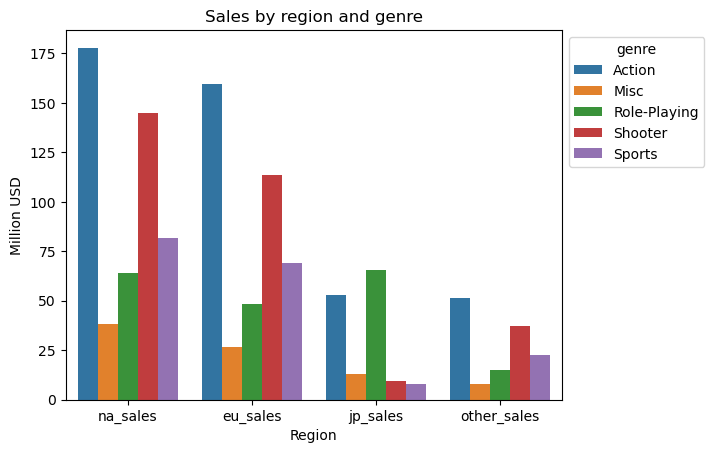

In [41]:
graph_genre = sns.barplot(data = genre_sales, 
                          x = 'region', 
                          y = 'sales', 
                          hue = 'genre')

plt.title('Sales by region and genre')
plt.xlabel('Region')
plt.ylabel('Million USD')
sns.move_legend(graph_genre, 'upper left', bbox_to_anchor = (1, 1))

plt.show()

De una gráfica anterior extrajimos los 5 géneros con mayores ventas, con esta gráfica podemos determinar que:
- Las ventas de videojuegos de acción en Norte América y la Unión europea son superiores a cualquier otra venta, en especial las de Norte América. 
- En Japón es la única región donde el género Role-Playing es el favorito en ventas. 


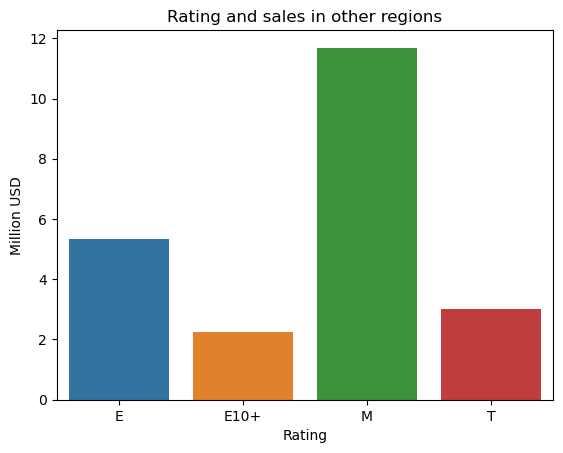

In [42]:
sns.barplot(data = region, 
                x = 'rating', 
                y = 'other_sales', 
                errorbar = None)

plt.title('Rating and sales in other regions')
plt.xlabel('Rating')
plt.ylabel('Million USD')

plt.show()

Según la gráfica, parece ser que las clasificaciones otorgadas por el ESRB no afectan las ventas, ya que siendo M de Mature la clasificación más restrictiva de las cuatro frente a los usuarios, esta es, por mucho, la que posee las mayores ventas, superando a las demás clasificaciones a las que mayor población tiene acceso debido a su edad.  

## 4. Prueba de hipótesis:

4.1 Las calificaciones promedio de los usuarios para las plataformas Xbox One y PC son las mismas.

4.2 Las calificaciones promedio de los usuarios para los géneros de Acción y Deportes son diferentes.

Explica:
- Cómo formulaste las hipótesis nula y alternativa.
- Qué criterio utilizaste para probar las hipótesis y por qué.

Para ambos casos estos serán los criterios a tener en cuenta: 

- Se usará el nivel de significancia estándar de **$alpha\$ de 0.05.**
- Se compararán dos categorías con respecto a una variable numérica ('user score'), aquí se desconocen las desviaciones estándar, es por ello que para **probar las hipótesis se usará el ttest.**

**4.1 Demostrar si las calificaciones promedio de los usuarios para las plataformas Xbox One y PC son las mismas.**

H0 = Las calificaciones promedio de los usuarios para las plataformas Xbox One y PC son las mismas.

H1 = las calificaciones promedio de los usuarios para las plataformas Xbox One y PC son diferentes.



In [43]:
#Generación de series de cada plataforma sin valores ausentes

score_xone = ice_df[ice_df['platform'] == 'XOne']['user_score'].dropna()

score_pc = ice_df[ice_df['platform'] == 'PC']['user_score'].dropna()

In [44]:
#Prueba de hipótesis

alpha = 0.05

results = st.ttest_ind(score_xone, score_pc) 

print(f"""
    La clasificación promedio de los usuarios para los juegos de Xbox One es: {score_xone.mean().round(2)}
    La clasificación promedio de los usuarios para los juegos de PC es: {score_pc.mean().round(2)}
    
    p-value: {results.pvalue}
""")

if results.pvalue < alpha:
    print("Rechazamos la hipótesis nula")
else:
    print("No podemos rechazar la hipótesis nula")



    La clasificación promedio de los usuarios para los juegos de Xbox One es: 6.52
    La clasificación promedio de los usuarios para los juegos de PC es: 7.07
    
    p-value: 1.3037979620149106e-05

Rechazamos la hipótesis nula


El rechazo de la hipótesis nula evidencia entonces que las calificaciones promedio de los usuarios para las plataformas Xbox One y PC son diferentes, y tenemos una prueba estadística que lo respalda.

**4.2 Demostrar si las calificaciones promedio de los usuarios para los géneros de Acción y Deportes son diferentes.**

H0 = Las calificaciones promedio de los usuarios para los géneros de Acción y Deportes son iguales.

H1 = Las calificaciones promedio de los usuarios para los géneros de Acción y Deportes son diferentes.

In [45]:
#Generación de series de cada género sin valores ausentes

score_action = ice_df[ice_df['genre'] == 'Action']['user_score'].dropna()

score_sport = ice_df[ice_df['genre'] == 'Sports']['user_score'].dropna()

In [46]:
#Prueba de hipótesis

alpha = 0.05

results = st.ttest_ind(score_action, score_sport) 

print(f"""
    La clasificación promedio de los usuarios para los juegos de acción es: {score_action.mean().round(2)}
    La clasificación promedio de los usuarios para los juegos de deportes es: {score_sport.mean().round(2)}
    
    p-value: {results.pvalue}
""")

if results.pvalue < alpha:
    print("Rechazamos la hipótesis nula")
else:
    print("No podemos rechazar la hipótesis nula")



    La clasificación promedio de los usuarios para los juegos de acción es: 7.06
    La clasificación promedio de los usuarios para los juegos de deportes es: 6.95
    
    p-value: 0.06480928064420527

No podemos rechazar la hipótesis nula


Según nuestra prueba estadística no podemos rechazar la hipótesis nula porque, efectivamente, las calificaciones promedio de los usuarios para los géneros de acción y deportes son muy similares entre sí, existiendo una diferencia de tan solo 0.11 puntos. 

## 5. Conclusiones finales



<div class="alert alert-block alert-info">
Tras el preprocesamiento de datos y el análisis consiguiente, estas son algunas de las conclusiones más notables:
    
- Determinaciones frente a los valores ausentes de la base de datos: 
    1. Los valores ausentes de la columnna 'name', al ser solo 2, se eliminarán, ya que son una muestra poco significatica y en ambos casos falta aún más información.
    2. Los datos ausentes de la columna 'year_of_release', al no representar un porcentaje significativo frente a todo el data frame, también se eliminará para no afectar las gráficas del análisis, además sus datos se cambiarán al tipo int. 
    3. Las columnas 'critic_score', 'user_score' y 'rating' se dejarán como datos ausentes, ya que al ser tantos, y tratarse de números, cambiarlos afectaría las operaciones matemáticas más adelante en el análisis.
    
    
   **Conclusiones parciales a partir del análisis:**
    - A partir de 2001 se supera el umbral de los 400 juegos lanzados por año, siendo un año con mucho más movimiento y que nos permite descartar años previos por sus bajas ventas. 
    - Las plataformas con más ventas de manera histórica son: 
        1. PlayStation 2
        2. Xbox 360
        3. PlayStation 3
        4. Nintendo Wii
        5. Nintendo DS
    - La mayoría de consolas tienen un periodo o ciclo de 'vida' en ventas de aproximadamente 10 años. 
    - Los picos en ventas de las consolas se alcanzan, por lo general, en los primeros 5 años tras su lanzamiento. 
    - Más o menos a mediados del periodo de vida de una consola, surge la siguiente con mayor éxito en ventas.
    
    **Datos a considerar para la proyección de 2017:**    
    - **Se considerará solo un periodo de 5 años previos al 2017, es decir, a partir del 2012** para las proyecciones. Esto con la intención de no sobreestimar las ventas de una consola al tomar su ciclo de vida completo.
    - Las plataformas líderes en ventas a partir del 2012 son: 
        1. PlayStation 4
        2. PlayStation 3
        3. Xbox 360
        4. Nintendo 3DS
        5. Xbox One
    - Existen diferencias significativas en ventas de una plataforma a otra, por ejemplo, el PS4, plataforma con más ventas, el 75 % de sus datos se concentran en ventas mayores a las que tuvo en este periodo de tiempo la Xbox One y el Nintendo 3DS; y siguiendo esta misma línea, ese 75 % de ventas de la PS4 rondan las mismas cifras que tan solo el 25 % de mayor ingreso del PS3 y la Xbox 360 lograron alcanzar en su mejor momento. 
    - El alcance de las ventas la Xbox One y el Nintendo 3DS es mucho más concentrado en cifras de 20 a 60 millones de USD, mientras que las otras consolas tienen picos y valles mucho más separados entre sí.
    - Al menos para el caso de la Xbox 360, las calificaciones positivas de los profesionales sí tienen una influencia en el aumento de las ventas, mientras que las de los usuarios no la tienen.
    - Para los juegos multiplataforma se tomaron dos versiones de Lego, en ambos casos hay una consola con mayor éxito en ventas frente a las demás y esta es la Xbox 360. Además, si bien las ventas pueden ser pequeñas, en todas las consolas en las que han salido, ambos juegos se han vendido, no fueron un fracaso total. 

    **Comparaciones por género:**
   - Existen 4 géneros favoritos, sus ventas siempre son superiores a las de los demás desde el 2012, estos son: 
        1. Action
        2. Shooter
        3. Role-playing
        4. Sports
   - El género Action, si bien estuvo en la cima en ventas por mucho y por más tiempo, llegando al 2016 fue superado en ventas por Shooter; sin embargo, hay que tener en cuenta que este último género parece estar decreciendo en ventas desde el último año al igual que todos los demás géneros favoritos. 
   - El género Misc es el quinto mejor en ventas, pero está muy por debajo de los otros cuatro.
    
    **Comparaciones por región:**    
   - Norte América y la Unión europea poseen las mejores ventas en conjunto, superando las de Japón y otras regiones. 
   - Las consolas favoritas en Norte América, Unión europea y Japón son Xbox 360, PS4 y Nintendo 3DS respectivamente.
   - Consolas como la Xbox One y la Xbox 360 no son populares y han generado un mínimo de ventas en Japón.
   - Las ventas de Xbox 360 en Norte América superan las ventas de cualquier otra consola en cualquier otra región.
   - Las ventas de videojuegos de acción en Norte América y la Unión europea son superiores a cualquier otra venta, en especial las de Norte América. 
   - En Japón es la única región donde el género Role-Playing es el favorito en ventas. 
   - Parece ser que las clasificaciones otorgadas por el ESRB no afectan las ventas, ya que siendo M de Mature la clasificación más restrictiva de las cuatro frente a los usuarios, esta es, por mucho, la que posee las mayores ventas, superando a las demás clasificaciones a las que mayor población tiene acceso debido a su edad.  
    
    
**CONCLUSIONES FINALES:**
    
- Para el 2017, si los públicos objetivos en ventas son Norte América y la Unión Europea, se recomienda lanzar videojuegos multiplataformas en las consolas PS4 y Xbox 360, cuyo género sea una combinación de acción y shooter (mayor carga en el tema de acción).
- Si el objetivo es el público de Japón, la mejor opción son los juegos de Role-Playing para el Nintendo 3DS, pero a sabiendas de que este no tendrá mucho éxito en otros mercados.
- El juego a lanzar debe tener muy buenas reseñas de los expertos desde el principio, si no las probabilidades de que sea un éxito al lanzarlo al mercado son bajas. 
    

    

    